In this notebook I will go through the step to combine BPASS data (SNe & GW event rates for a specific population) with data from the Millenium simulation, specifically the star formation rate. 

In this example, we will **NOT** take metallicity into account!


We will first look at the BPASS data and manipulate it such that it is in the correct format. Then we will look at the Millenium simulation and extract the SFR. And finally we will combined them.

# 1. BPASS

In [1]:
import pandas as pd
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
import kea.load
import kea.rates
import kea.plot
import argparse
from kea.constants import *

plt.rcParams.update({'font.size': 22})

h = 0.73
now = 13.799
data_folder = "../../data/"
ccsn_types = ['IIP', 'II', 'Ib', 'Ic']
SNe_types = ["ccsn", "Ia", "LGRB", "PISNe"]
GW_types = ["BHBHv22hobbs", "BHNSv22hobbs", "NSNSv22hobbs"]
types = SNe_types + GW_types

# 1. Extract SFRD from the Millenium Simulation

To get a quantity we can compare, we will try to get the Stellar Formation Rate Density instead of the SFR. This such that we can compare the quantity to other methods used. 

## 1.1 Read the cosmological simulation

In [2]:
cosmod = pd.read_csv(data_folder+"cosmological_simulation/Millenium_Simulation.dat", comment="#")
tr = pd.read_csv(data_folder+"cosmological_simulation/timerel.dat", comment="#")

## 1.2 Get the Stellar Formation Rate Density


The contributions of individual galaxies are added together and divided by the volume of the simulation. 

       D = 62.5/h Mpc
       
The SFR has units M$_\odot$/yr and SFRD has M$_\odot$/yr/Mpc$^3$


Because the binning of the simulation is not the same as that of BPASS, it's necessary to interpolate the SFRD. 
It is a relatively highly samples function and can therefore use linear splines to interpolate between different points. 


In [3]:
SFRD = kea.rates.getSFRD(cosmod, tr, 62.5, h)
SFRDfunc = interpolate.splrep(np.flip(tr["lookbackTime"]*1e9), np.flip(SFRD), k=1)
ynew = interpolate.splev(tr["lookbackTime"]*1e9, SFRDfunc, der=0)

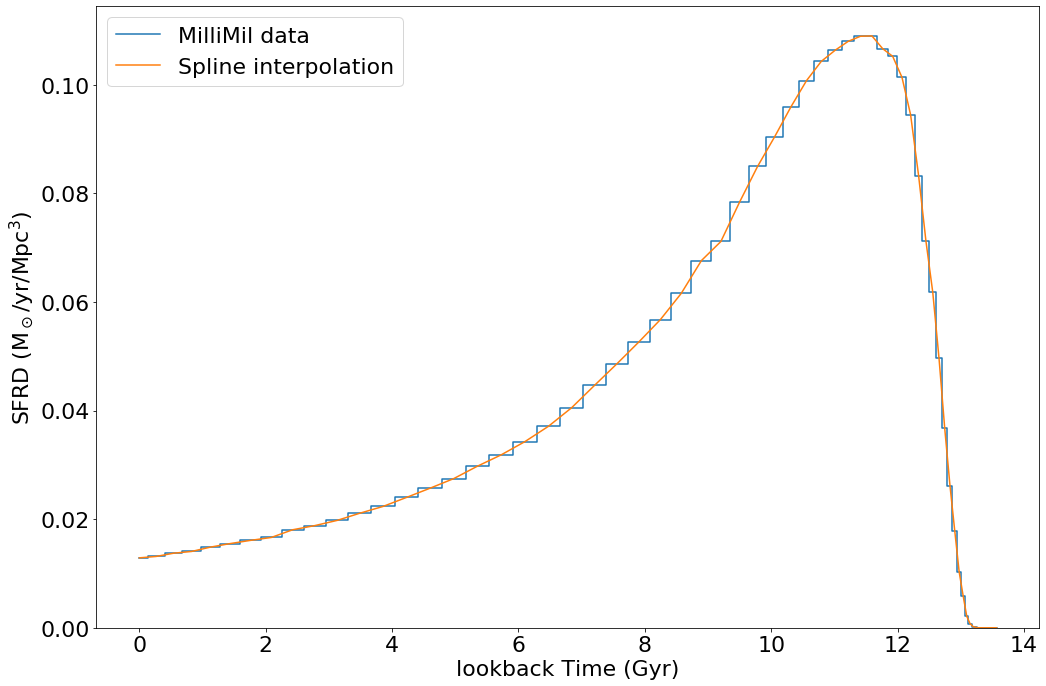

In [4]:
fig = plt.figure(figsize=(15,10))
kea.plot.plotSFRD(SFRD, SFRDfunc, tr["lookbackTime"].values)
plt.show()

# Extract the Transient Event rate data (BPASS)


## 2.1 Read the SNe & GW data
 
The load functions retrieve the data from the given files and normalise the data such that the events are in units
$\text{#events/yr/M}_\odot$.

The data is stored in special `BPASS_hist`s to allow for easy manipulation and integration/summation over values in the histogram. Furthermore, the logarithmic binning of BPASS is hard to perform any rebinning on. Thus, `BPASS_hist` combines a linear internal representation with a the logarithmic binning used in plotting. 

Data can be inputted in linear and in logarithmic fashion. A later notebook will provide more information of this. 

In [5]:
SNe_rates = kea.load.loadBPASS(data_folder+"bpass_v2.2.1_imf135_300/supernova-bin-imf135_300.z002.dat")
GW_rates = kea.load.loadGW(data_folder+"GWrates/v2.2hobbs/gwmergerdata.z002.dat")

ccsn = np.zeros(51)   
for j in ccsn_types:
     ccsn += SNe_rates[j]

SNe_rates["ccsn"] = ccsn

# 2.2 Plot the normalised rates

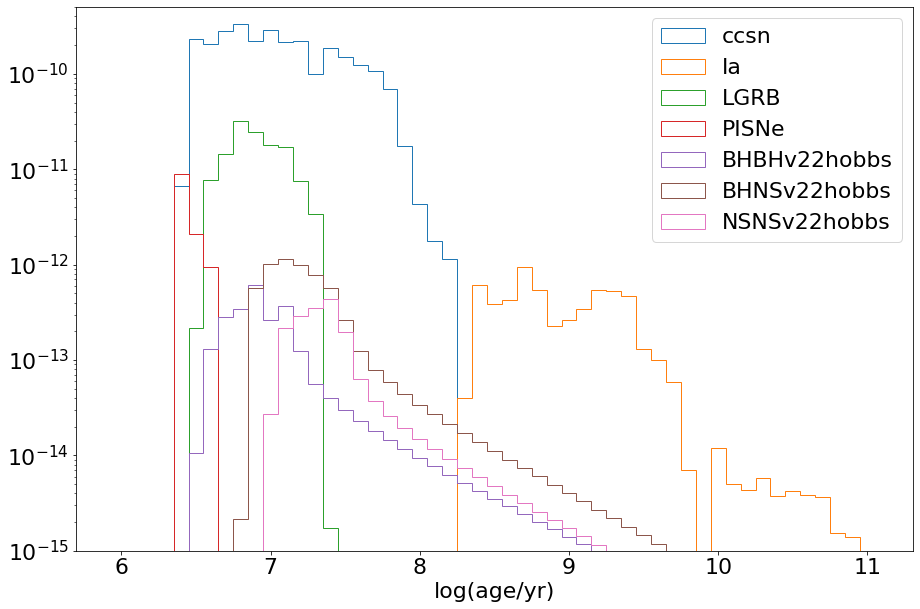

In [6]:
fig2 = plt.figure(figsize=(15,10))

for i in SNe_types:
    hist = kea.hist.histogram_BPASS(SNe_rates[i])
    hist.plotLog(label=i)


for i in GW_types:
    hist = kea.hist.histogram_BPASS(GW_rates[i])
    hist.plotLog(label=i)
    
plt.yscale("log")
plt.legend()
plt.ylim(1e-15, 5e-10)
plt.show()

# 3. Combining the rates


We have to be very considerate of the binning when combining the models. 

Our final event rate will be over the lookback time. 

To make this easier the data is stored in a `histogram` with a custom number of bins.
From the cosmological simulation we have an SFRD in M$_\odot$/yr/Mpc$^3$ and from BPASS we get #events/yr/M$_\odot$.

To combine these we must find the total amount of matter created within a bin. 

This is done by taking the bin edges in time and integrating the SFRD between them. This action is performed by the `calculate_mass_per_bin` function, which gives us the amount of mass per bin.

We then turn out attention to the BPASS events. To get the actual number of events per bin, we integrate the BPASS rate between each bin edge of the final histogram binning and multiply it with the mass present in the original bin. We then move on to the next time bin and repeat the process. This is performed by the `calculate_event_rates` function.

Thus, to repeat: 

1. For each bin in the final histogram, we take the bin edges (t1 & t2).
2. We caluclate the new mass in that bin by taking the integral from t1 to t2 of the SFRD. 
3. We integrate over the BPASS histogram, where t2 is now the origin and t1' = t2 - t1. We do this for each bin we have passed in the final histogram. So for bin1 we only integrate over the first bin, but for bin2, we now have the following integrations in the BPASS histogram: 
    t3 is now the origin
    t2' = t3 - t2 (bin2)
    t1' = t3 - t1 (bin1)
    etc for the next bin in the final histogram. 
4. We multiply the integral with the mass in our bins and add the events to the BPASS bin we performed the integral over.

In [7]:
nr_bins = 1000
edges = np.linspace(0,NOW, nr_bins)


# Calculate the amount of mass per bin
mass_per_bin = kea.rates.calculate_mass_per_bin(edges, SFRDfunc)


event_rates = {}
for i in SNe_types:
    event_rates[i] = kea.rates.calculate_event_rates(edges, mass_per_bin, SNe_rates[i].values)
    
for i in GW_types:
    event_rates[i] = kea.rates.calculate_event_rates(edges, mass_per_bin, GW_rates[i].values)


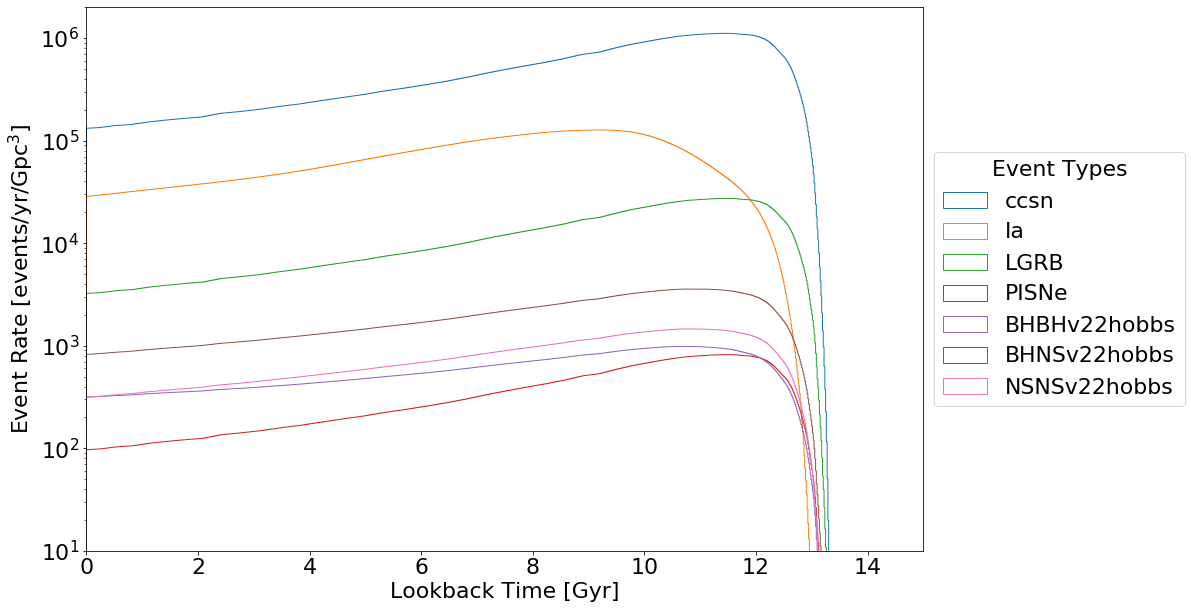

In [8]:
fig3 = plt.figure(figsize=(15,10))
for i in event_rates:
    hist = kea.hist.histogram(edges, event_rates[i])
    hist.plot(label=i)
    
plt.ylabel("Event Rate [events/yr/Gpc$^3$]")
plt.xlabel("Lookback Time [Gyr]")
plt.yscale("log")
plt.xlim(0,15)
plt.ylim(10,2e6)
plt.legend(title="Event Types", loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
